In [15]:
import json
import yaml
import pandas as pd
import tensorflow as tf
import yaml
from dvclive.keras import DVCLiveCallback
import numpy as np


import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)


In [16]:
from IPython import get_ipython
ip = get_ipython()
ip.magic("reload_ext autoreload")  # these will enable module autoreloading
ip.magic("autoreload 2")

/tmp/ipykernel_2184607/1477615771.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ip.magic("reload_ext autoreload")  # these will enable module autoreloading
/tmp/ipykernel_2184607/1477615771.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ip.magic("autoreload 2")


In [17]:
params = yaml.safe_load(open("params.yaml"))
plt.style.use(['science','no-latex','grid',])

train_df = pd.read_csv("PFC report/rnn_direct_best_model/train_2022-11-22 01:36:11.169464_SINGLE-SHOT_['RNN', 'RNN']", index_col='din_instante')
val_df = pd.read_csv("PFC report/rnn_direct_best_model/val_2022-11-22 01:36:11.169464_SINGLE-SHOT_['RNN', 'RNN']", index_col='din_instante')
df_target = pd.read_csv('data/target/target_df.csv', index_col='Data')

with open("PFC report/rnn_direct_best_model/history_2022-11-22 01:36:11.169464_SINGLE-SHOT_['RNN', 'RNN']", "r") as history_file:
    history = json.load(history_file)

pred_list = [train_df,val_df]

In [7]:
# train_df.head()
# val_df.head()
#history

In [9]:
def learning_curves(history, skip, plot=False, model_name='rnn', zoom=False):

    fig, ax = plt.subplots(figsize=(13, 18), nrows=3, ncols=1)
    metrics_list = [
        "loss",
        "val_loss",
        "mean_absolute_error",
        "val_mean_absolute_error",
        "root_mean_squared_error",
        "val_root_mean_squared_error",
    ]

    name_dict = {0: "Treino", 1: "Validação"}
    for i, metric in enumerate(metrics_list):
        # plot train and validation metrics on the same plot
        if i <= 1:
            ax1 = ax.ravel()[0]
        elif i > 1 and i <= 3:
            ax1 = ax.ravel()[1]
        else:
            ax1 = ax.ravel()[2]

        if (i % 2) == 0:
            curve_label = "Treino"
            color = 'orange'
        else:
            curve_label = "Validação"
            color = 'green'

        sns.lineplot(
            x=range(skip, len(history[metric])),
            y=history[metric][skip:],
            ax=ax1,
            label=curve_label,
            color=color
        )

    if zoom:
        zoom_title = '- zoom'
        ax.ravel()[0].set_ylim(0)
        ax.ravel()[1].set_ylim(0)
        ax.ravel()[2].set_ylim(0)

    else: 
        zoom_title =''
    ax.ravel()[0].set_title(f"Learning Curve: EMQ (custo) - {model_name} {zoom_title}")
    ax.ravel()[1].set_title(f"Learning Curve: EMA - {model_name} {zoom_title}")
    ax.ravel()[2].set_title(f"Learning Curve: REMQ - {model_name} {zoom_title}")

    for x in range(0,3):
        ax.ravel()[x].set_xlabel('epochs')

    if plot:
        plt.show()

    return fig


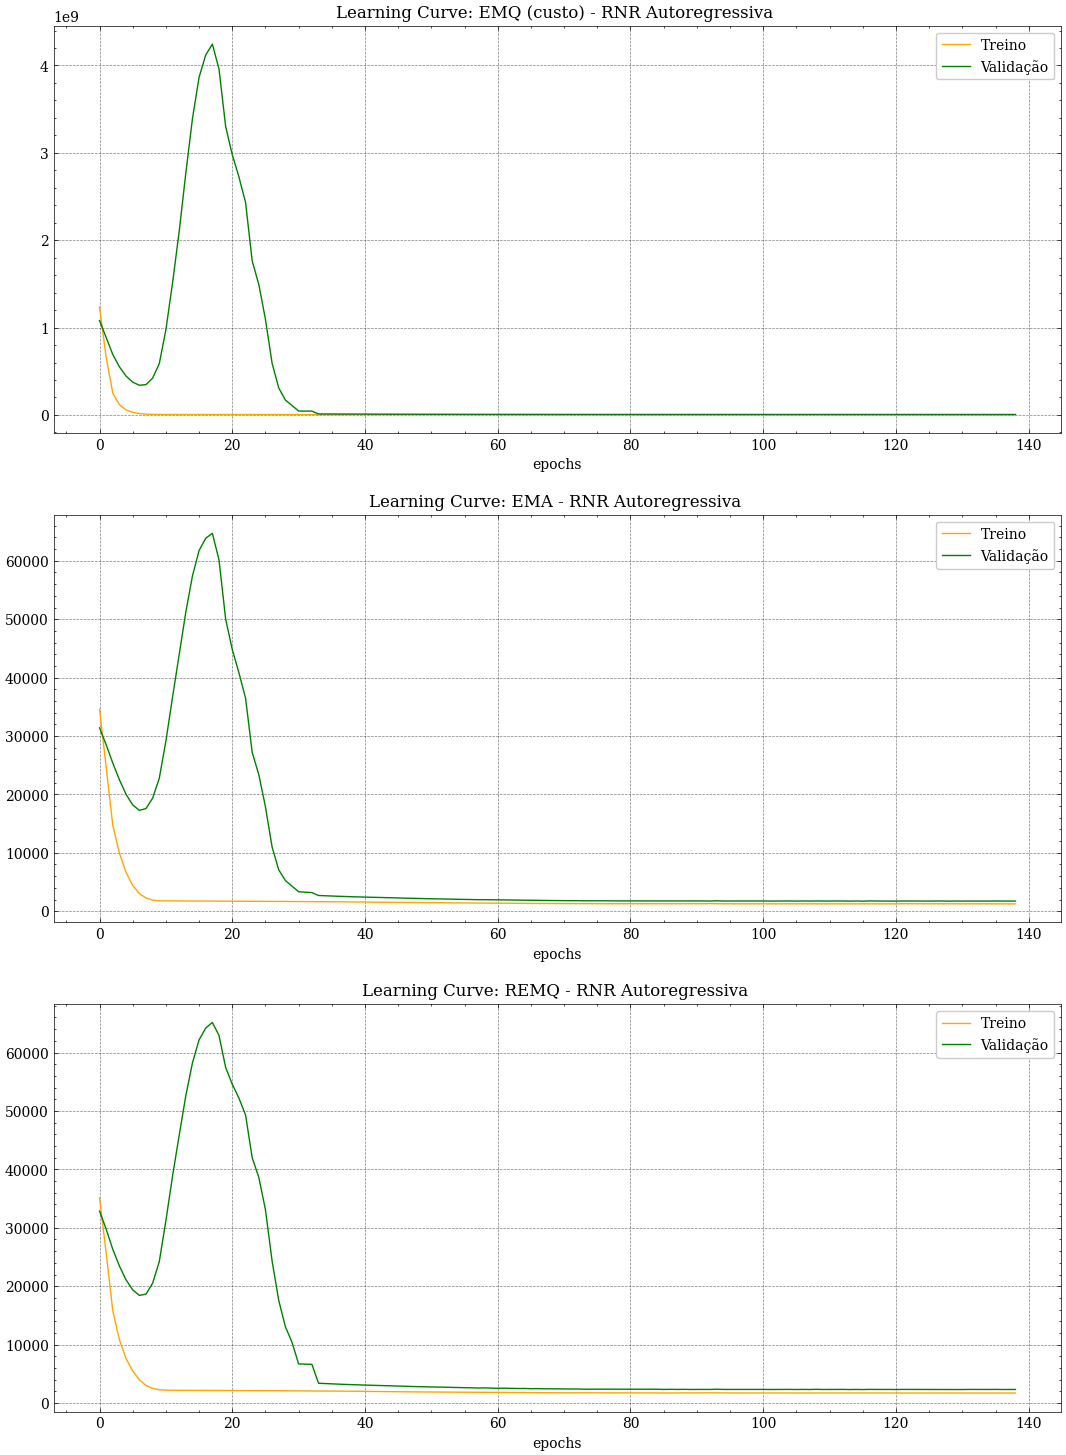

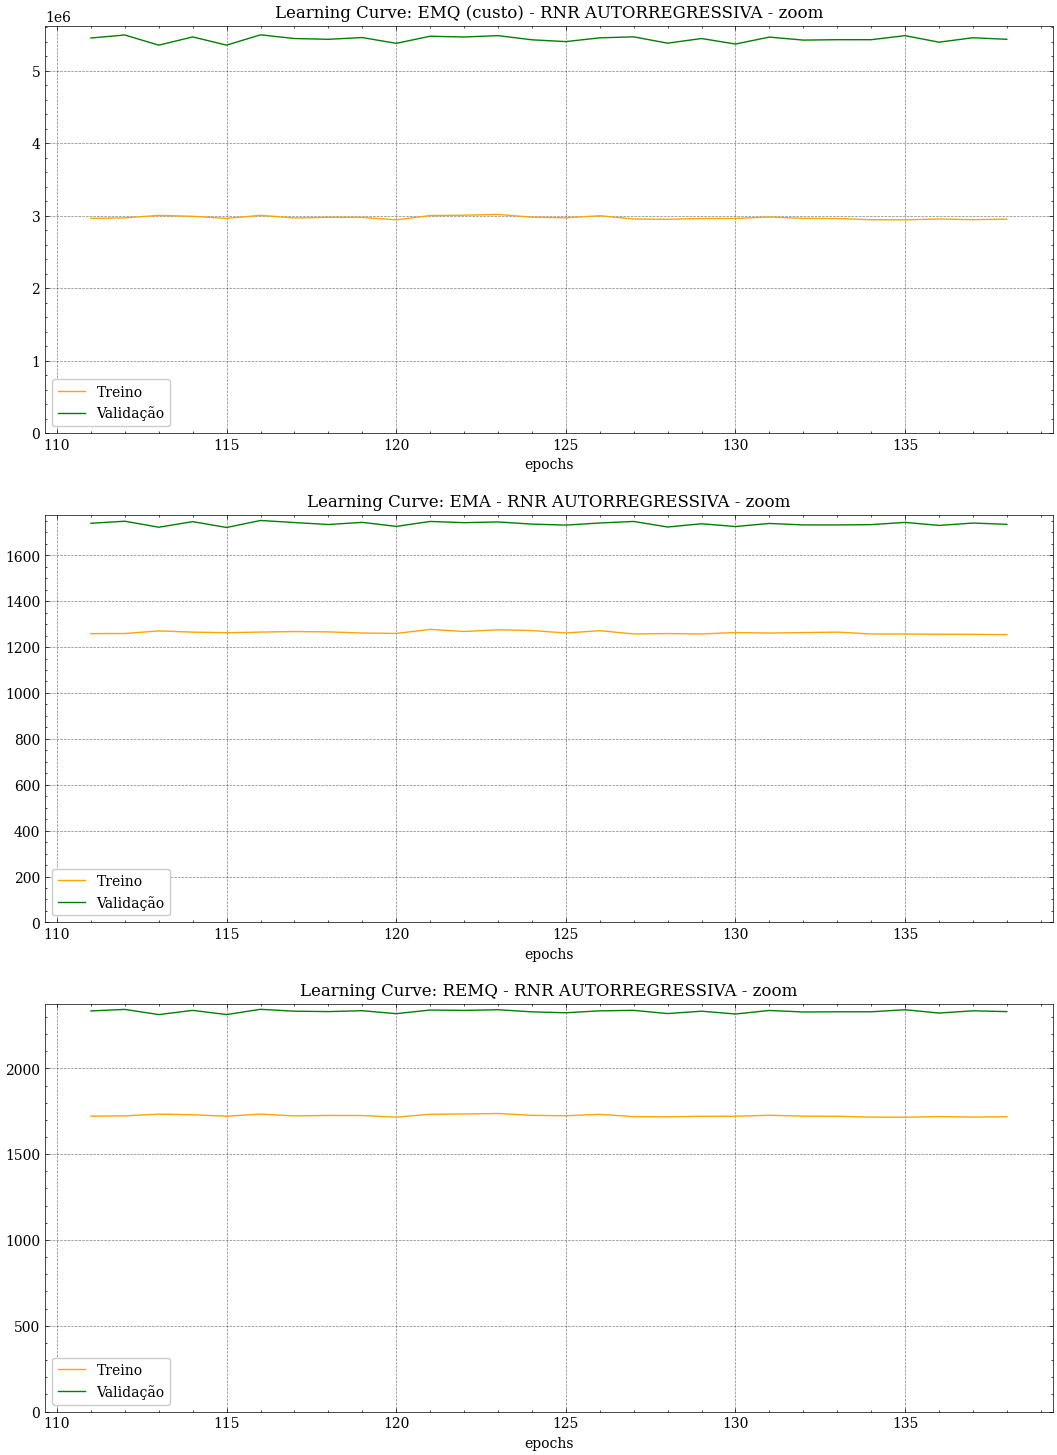

In [10]:
lc_fig = learning_curves(history=history, skip=0, plot=True, model_name="RNR Autoregressiva")
lc_fig2 = learning_curves(history=history, skip=int(len(history['loss'])*0.8), plot=True, model_name="RNR AUTORREGRESSIVA", zoom = True)
# lc_fig.savefig("PFC report/rnn_ar_best_model/learning_curves.png")
# lc_fig2.savefig("PFC report/rnn_ar_best_model/learning_curves.png")

In [72]:
def plot_predicted_series(pred_list, df_target, plot=False,figsize=(12,18),iterate_over=range(0,5)):


    window_size = pred_list[0].shape[1] - 6

    colors = ["orange", "green"]
    dataset_names = ["Treino", "Validação"]
    
    fig = plt.figure(figsize=figsize)    
    gs = fig.add_gridspec(len(iterate_over), hspace=0.30)
    ax = gs.subplots(sharex=False)

    # loop over 5 weeks
    for enumerator, week_count in enumerate(iterate_over):

        extra = plt.Rectangle(
            (0, 0), 0, 0, fc="none", fill=False, ec="none", linewidth=0
        )

        # plot measured data
        sns.lineplot(
            x=df_target.iloc[week_count:].index,
            y=df_target[f"Semana {week_count+1}"].iloc[: -week_count or None],
            ax=ax.ravel()[enumerator],
            color="teal",
            label="Carga Real",
        )

        # plot predicted data
        for pred_set, color, ds_name in zip(pred_list, colors, dataset_names):
            
            # shift index so it shows date of prediction
            true_index = pred_set.index.astype("datetime64[ns]") + pd.Timedelta(
                value=7 * (window_size - 1), unit="d"
            )  # -1
            x_value = [str(index_unit).split(" ")[0] for index_unit in true_index]
            y_value = pred_set.loc[:, f"previsão semana {week_count+1}"].values

            sns.lineplot(
                x=x_value,
                y=y_value,
                ax=ax.ravel()[enumerator],
                color=color,
                label=ds_name,
            )

        ax.ravel()[enumerator].set_title(
            f"Carga real vs Predição em todo o período - Semana {week_count+1}"
        )

        # calculate scores
        score_list_by_dataset = []

        for pred_set in pred_list:
            pred_set_to_avaluate = pred_set.iloc[:-3]
            # generate true date index
            score_list_by_dataset.extend(
                [
                    mean_squared_error(
                        pred_set_to_avaluate.loc[:, f"previsão semana {week_count+1}"],
                        df_target[f"Semana {week_count+1}"].loc[
                            pred_set_to_avaluate["Data Previsão"].values
                        ],
                        squared=False,
                    ),
                    mean_absolute_percentage_error(
                        pred_set_to_avaluate.loc[:, f"previsão semana {week_count+1}"],
                        df_target[f"Semana {week_count+1}"].loc[
                            pred_set_to_avaluate["Data Previsão"].values
                        ],
                    )
                    * 100,
                ]
            )

        scores = (
            r"REMQ Train = {:.0f}"
            + "\n"
            + r"EMAP Train = {:.2f}%"
            + "\n\n"
            + r"REMQ val = {:.0f}"
            + "\n"
            + r"EMAP val = {:.2f}%"
        ).format(*score_list_by_dataset)

        # ax[enumerator].add_artist(plt.legend(loc="lower right"))

        legend_metrics = ax[enumerator].legend([extra], [scores], loc="upper left")

        # ax[enumerator].add_artist(legend_metrics)
        # ax[enumerator].add_artist(legend_lines)

        # add rectangle patch
        ax[enumerator].add_patch(extra)
        ax[enumerator].add_artist(legend_metrics)
    
        # patch coordinates
        extra_x, extra_y = extra.get_xy()
        cx = extra_x + extra.get_width() / 2.0
        cy = extra_y + extra.get_height() / 2.0
        ax.ravel()[enumerator].annotate(
            scores,
            (cx, cy),
            color="black",
            weight="bold",
            fontsize=10,
            ha="center",
            va="center",
        )

        # np.ravel(ax)[enumerator].legend(loc='upper left')

        ax.ravel()[enumerator].xaxis.set_major_locator(mdates.MonthLocator())
        ax.ravel()[enumerator].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=1))

        for label in ax.ravel()[enumerator].get_xticklabels(which="major"):
            label.set(rotation=30, horizontalalignment="right")


    if plot:
        plt.show()
    return fig


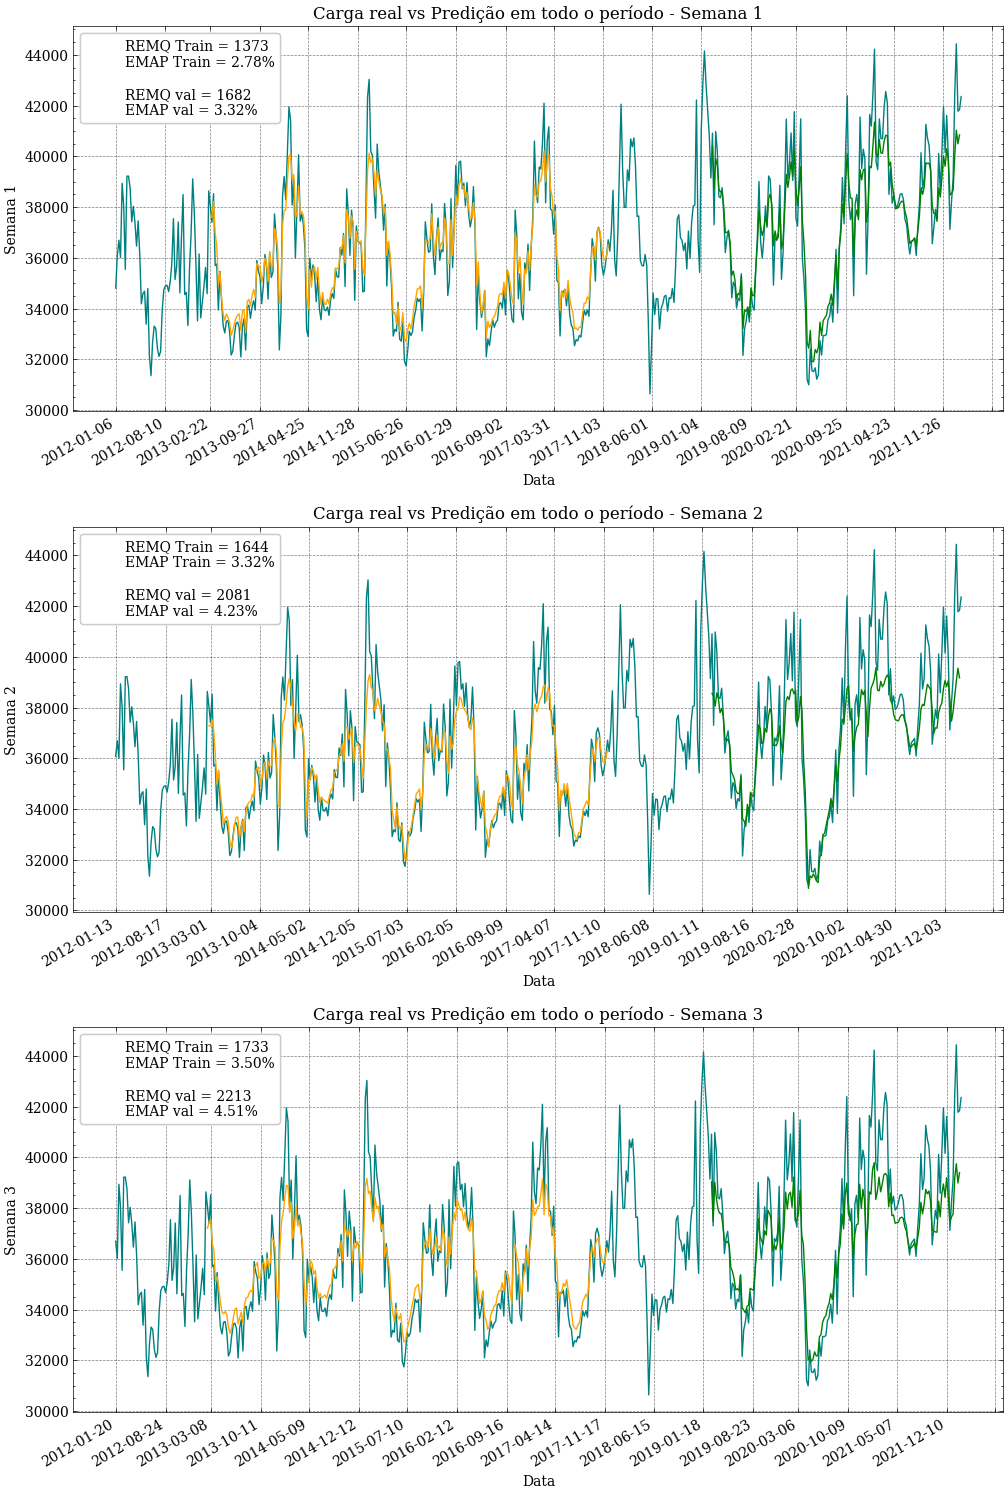

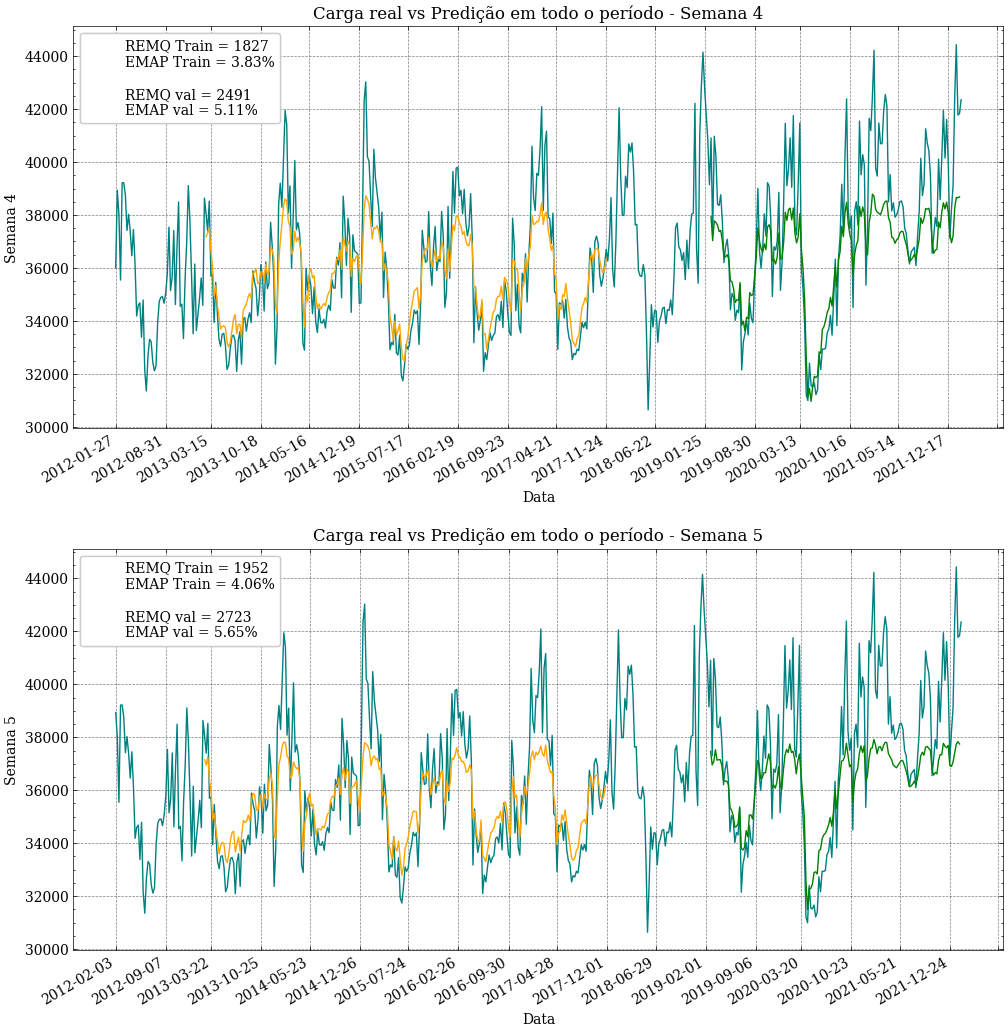

In [73]:
pred_series_fig = plot_predicted_series(
    pred_list=pred_list, 
    df_target=df_target, 
    plot=True, 
    figsize=(12,18), 
    iterate_over=range(0,3)
)
pred_series_fig2 = plot_predicted_series(
    pred_list=pred_list, 
    df_target=df_target, 
    plot=True, 
    figsize=(12,12), 
    iterate_over=range(3,5)
)
# pred_series_fig.savefig("PFC report/rnn_ar_best_model/prediction_series pt1.png")
# pred_series_fig2.savefig("PFC report/rnn_ar_best_model/prediction_series pt2.png")


In [14]:
def generate_metrics_semana(df_target, pred_list, plot=False,figsize=(12,18),title_mod=''):
    """Generates metrics for prediction performance of the 5 predicted weeks
    and generates plot for such metrics

    Args:
        df_target (_type_): dataframe with target values
        pred_list (_type_): list with predictions for train, val and test dataset as items
        id (_type_): _description_
        save (bool, optional): If True, saves plots as png. Defaults to False.
        plot (bool, optional): If True, show plots. Defaults to False.

    Returns:
        _type_: list with dataframes of
    """
    name_dict = {0: "treino", 1: "validação", 2: "teste"}

    fig, ax = plt.subplots(figsize=figsize, nrows=3)

    train_metrics_df = pd.DataFrame(index=[f"Semana {week}" for week in range(1, 6)])
    val_metrics_df = pd.DataFrame(index=[f"Semana {week}" for week in range(1, 6)])
    test_metrics_df = pd.DataFrame(index=[f"Semana {week}" for week in range(1, 6)])
    metrics_df_list = [train_metrics_df, val_metrics_df, test_metrics_df]

    mae_plot_list = [0, 0]
    mape_plot_list = [0, 0]
    rmse_plot_list = [0, 0]

    colors_list = ["orange", "green"]

    # df_set will take the values: train_pred, val_pred and test_pred
    for i, pred_set in enumerate(pred_list):

        # drop last rows with nan values from autoregressiveness, if it's on
        # 3 samples makes no difference so we drop them anyway
        pred_set_to_avaluate = pred_set.iloc[:-3]

        mae_list = []
        mape_list = []
        rmse_list = []

        # loops the five weeks
        for week in range(0, 5):

            # adds mae of each week to mae_list
            mae_list.append(
                mean_absolute_error(
                    pred_set_to_avaluate.loc[:, f"previsão semana {week+1}"],
                    df_target[f"Semana {week+1}"].loc[
                        pred_set_to_avaluate["Data Previsão"].values
                    ],
                )
            )

            # adds mape of each week to mape_list
            mape_list.append(
                mean_absolute_percentage_error(
                    pred_set_to_avaluate.loc[:, f"previsão semana {week+1}"],
                    df_target[f"Semana {week+1}"].loc[
                        pred_set_to_avaluate["Data Previsão"].values
                    ],
                )
                * 100
            )

            # adds mse of each week to rmse_list
            rmse_list.append(
                mean_squared_error(
                    pred_set_to_avaluate.loc[:, f"previsão semana {week+1}"],
                    df_target[f"Semana {week+1}"].loc[
                        pred_set_to_avaluate["Data Previsão"].values
                    ],
                    squared=False,
                )
            )

        legend_text_mae = (r"EMA médio {} = {:.0f} $\pm$ {:.0f}").format(
            name_dict[i], np.mean(mae_list), np.std(mae_list)
        )
        legend_text_mape = (r"EMAP médio {} = {:.2f}% $\pm$ {:.2f}%").format(
            name_dict[i], np.mean(mape_list), np.std(mape_list)
        )
        legend_text_rmse = (r"REMQ médio {} = {:.0f} $\pm$ {:.0f}").format(
            name_dict[i], np.mean(rmse_list), np.std(rmse_list)
        )

        # plot EMA by week
        mae_plot_list[i] = sns.lineplot(
            x=range(1, 6),
            y=mae_list,
            ax=ax[0],
            color=colors_list[i],
            label=legend_text_mae,
        )
        # plot mape by week
        mape_plot_list[i] = sns.lineplot(
            x=range(1, 6),
            y=mape_list,
            ax=ax[1],
            color=colors_list[i],
            label=legend_text_mape,
        )
        # plot EMQ by week
        rmse_plot_list[i] = sns.lineplot(
            x=range(1, 6),
            y=rmse_list,
            ax=ax[2],
            color=colors_list[i],
            label=legend_text_rmse,
        )

        # saves weekly metrics to a df
        metrics_df_list[i]["EMA"] = mae_list
        metrics_df_list[i]["EMAP"] = mape_list
        metrics_df_list[i]["REMQ"] = rmse_list

    ax[0].set_title(f"EMA das inferências por semana - {title_mod}")
    ax[0].set_xticks(
        [1, 2, 3, 4, 5],
        labels=["Semana 1", "Semana 2", "Semana 3", "Semana 4", "Semana 5"],
    )
    ax[1].set_title(f"EMAP das inferências por semana - {title_mod}")
    ax[1].set_xticks(
        [1, 2, 3, 4, 5],
        labels=["Semana 1", "Semana 2", "Semana 3", "Semana 4", "Semana 5"],
    )
    ax[2].set_title(f"REMQ das inferências por semana - {title_mod}")
    ax[2].set_xticks(
        [1, 2, 3, 4, 5],
        labels=["Semana 1", "Semana 2", "Semana 3", "Semana 4", "Semana 5"],
    )
    for x in range(3):
        ax[x].legend(loc="lower right")
        ax[x].set_ylim(0)
        ax[2].legend(loc="lower right")

    if plot:
        plt.show()
    return metrics_df_list, fig


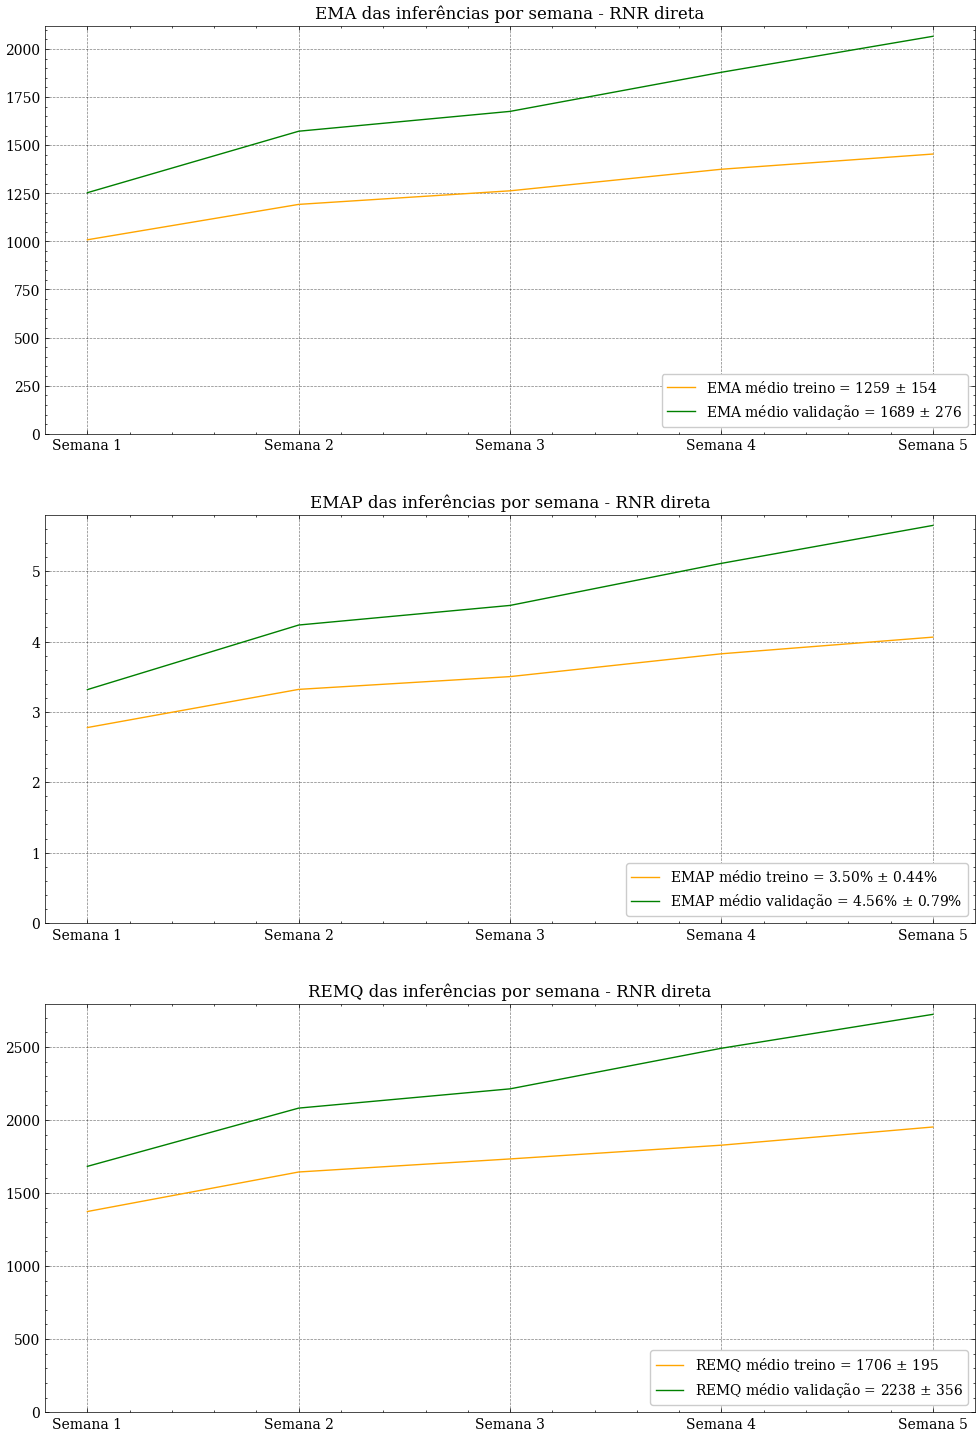

In [15]:
# generates metrics for the 5 weeks and plots
metricas_semana, metricas_fig = generate_metrics_semana(
        df_target, pred_list, plot=True, figsize=(12,18), title_mod = 'RNR direta'
)
# metricas_fig.savefig("PFC report/rnn_ar_best_model/metrics_semana.png")


In [8]:
def plot_residual_error(df_target, pred_list,plot=False,figsize=(12,18), iterate_over=range(5)):
    # variation from one week to the next
    res_baseline = df_target[
        "Resíduo"
    ]  # - df_target['Resíduo'].mean())/df_target['Resíduo'].max()
    # prediction residues
    colors = ["orange", "green", "purple"]
    
    fig = plt.figure(figsize=figsize)    
    gs = fig.add_gridspec(len(iterate_over), hspace=0.30)
    ax = gs.subplots(sharex=False)
    
    window_size = pred_list[0].shape[1]-6

    for week in iterate_over:

        # diferença normalizada entre semanas consecutivas
        # sns.lineplot(y=res_baseline, x=df_target['Data'], ax=ax[week])
        res_list = []
        for pred_set, color in zip(pred_list, colors[: len(pred_list)]):
            pred = pred_set.iloc[:-3]
            res_pred = (
                pred.loc[:, "previsão semana 1"].values
                - df_target[f"Semana {week+1}"].loc[pred["Data Previsão"]].values
            )
            x_value = pred["Data Previsão"].astype("datetime64[ms]") + pd.Timedelta(
                value=7 * (window_size - 1), unit="d"
            )
            sns.lineplot(y=res_pred, x=pred["Data Previsão"], ax=ax[week], color=color)
            res_list.append(res_pred)

        ax[week].set_title(f"Resíduo - Semana {week+1}")
        ax[week].legend("")
        ax[week].xaxis.set_major_locator(mdates.MonthLocator())
        ax[week].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=1))

        for label in ax[week].get_xticklabels(which="major"):
            label.set(rotation=30, horizontalalignment="right")

    if plot:
        plt.show()
    return fig, res_list

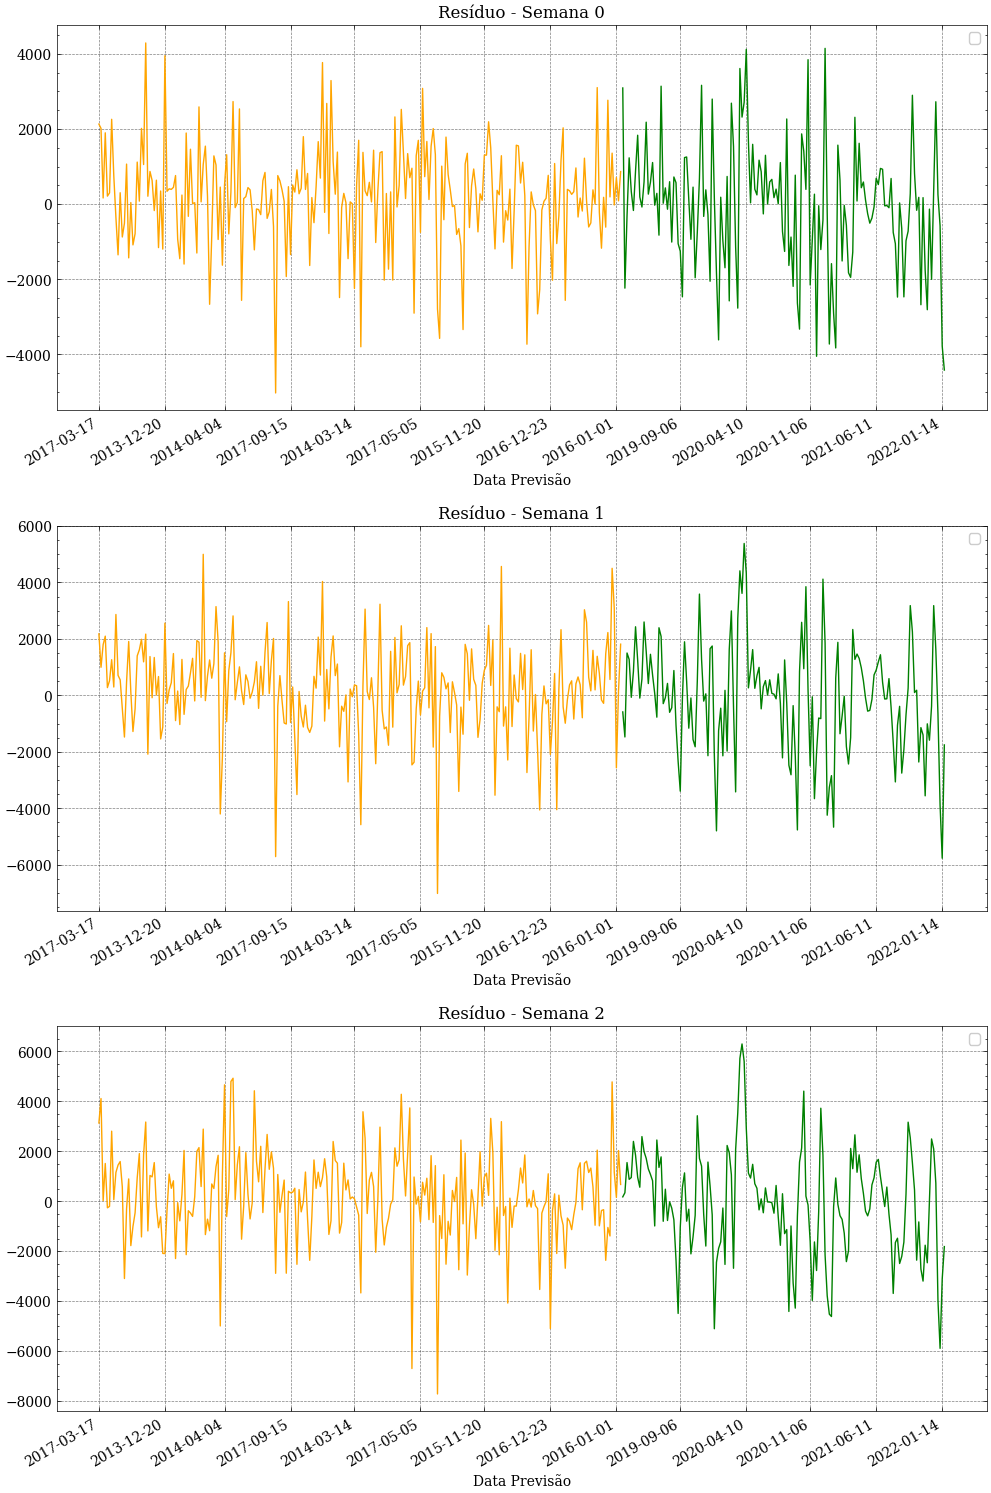

In [9]:
residual_fig, res_list = plot_residual_error(df_target, pred_list,figsize=(12,18),iterate_over=range(0,3), plot=True)
# residual_fig.savefig("PFC report/rnn_ar_best_model/residuo.png")
